In [1]:
%pylab inline
# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path+".TKA", 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset

Populating the interactive namespace from numpy and matplotlib


In [8]:
calibr = array([
    array([  # ch
        183,
        180,
        177,
        173,
        166,
        153,
        139,
        126,
        112,
        99,
        98,
        85,
        71,
        58,
        54,
        51,
        48,
        44,
        41,
        38,
        35,
        32,
        30,
        28,
        28,
        27,
        27,
        27
    ]),array([  # t
        190.5,
        186.5,
        182.5,
        178.5,
        170.5,
        154.5,
        132.5,
        122.5,
        106.5,
        90.5,
        90,
        74,
        58,
        42,
        38,
        34,
        30,
        26,
        22,
        18,
        14,
        10,
        6,
        2,
        1.5,
        1,
        0.5,
        0
    ])+3*2.5
])

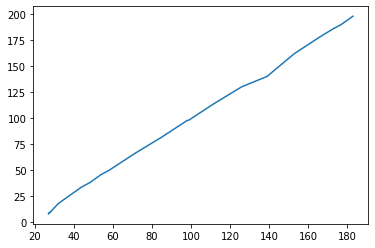

In [7]:
plt.plot(*calibr)

In [64]:
def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)

def val(x):
    return unumpy.nominal_values(x)

def err(x):
    return unumpy.std_devs(x)

In [14]:
[slope,offset], R_2=linfit_pm(*calibr)

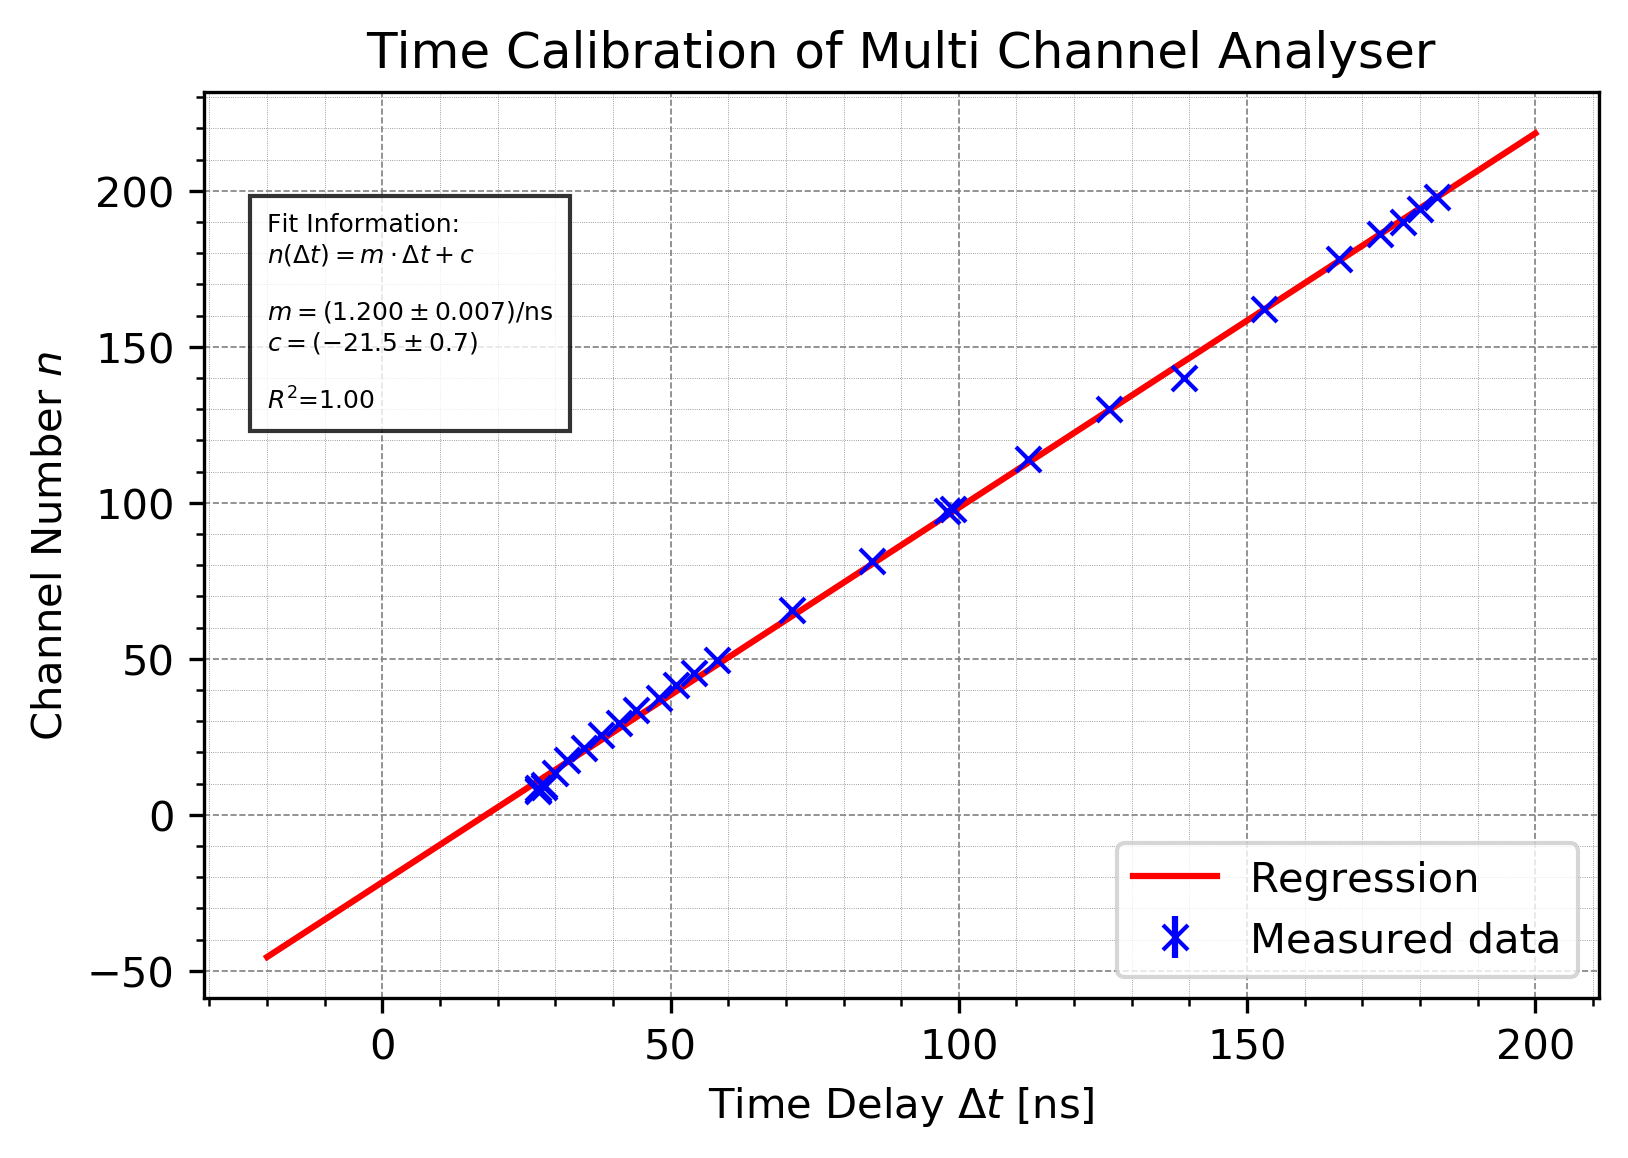

In [74]:
from uncertainties import unumpy as unp
x=np.linspace(-20,200)
y=x*slope+offset
plt.figure(dpi=300)
plt.title('Time Calibration of Multi Channel Analyser')
plt.ylabel('Channel Number $n$')
plt.xlabel(r'Time Delay $\Delta t$ [ns]')

plt.errorbar(calibr[0],calibr[1],yerr=0.5,fmt="bx",label="Measured data")
plt.plot(x,unumpy.nominal_values(y),"r-",label="Regression")

plt.grid(which='major',linestyle='--', color='grey',linewidth=0.4)
plt.grid(which='minor',linestyle=':', color='grey',linewidth=0.2)
plt.minorticks_on()

plt.legend(loc=4)
plt.text(-20, 130,
         'Fit Information:\n$n(\\Delta t)=m\\cdot \\Delta t +c $\n\n$m=({:.3f}\\pm {:.3f})$/ns\n$c=({:.1f}\\pm {:.1f})$\n\n$R^2$={:.2f}'
         .format(val(slope),err(slope),val(offset),err(offset),R_2), bbox={'facecolor':'white', 'alpha':0.8}, fontsize=6)
plt.savefig("time_cal.png")
plt.show()